# Ultimate DS Challenge

## Imports and Initializations

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('darkgrid')

## Part 1 ‑ Exploratory data analysis

### Read data from logins.json

In [4]:
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### Aggregate for 15 min time intervals

In [5]:
logins_15min_df = logins_df
logins_15min_df['count'] = 1
logins_15min_df = logins_15min_df.groupby(by='login_time', as_index=True).sum()
logins_15min_df.head()

,count
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1


In [6]:
logins_15min_df = logins_15min_df.resample('15Min').sum()
logins_15min_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Visualize 15 minute login counts

#### 15 minute time plot

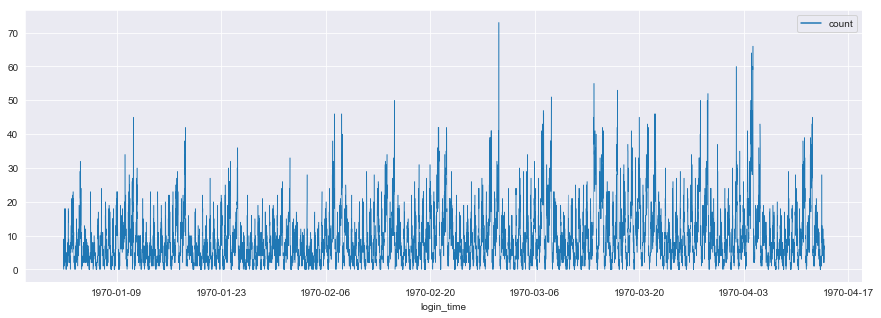

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=logins_15min_df, ax=ax, linewidth=.5)

#### Daily total counts time plot

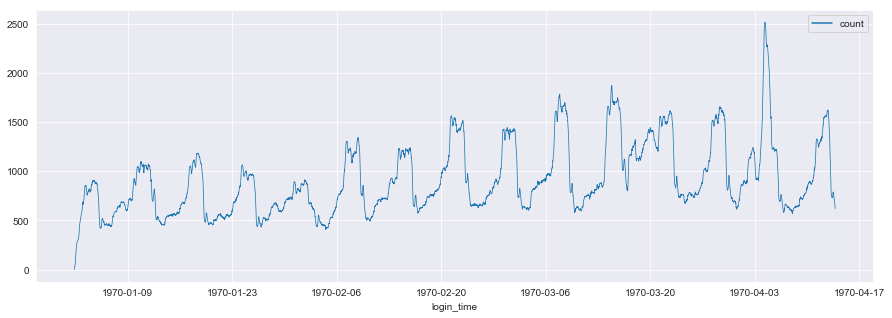

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=logins_15min_df.rolling('1d').sum(), ax=ax, linewidth=.75)

#### Weekly average counts time plot 

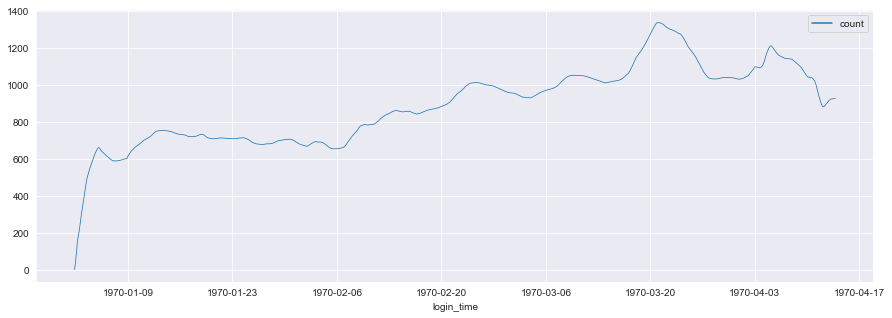

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=logins_15min_df.rolling('1d').sum().rolling('7d').mean(), ax=ax, linewidth=.75)

#### Auto-correlation and Partial Auto-correlation plot

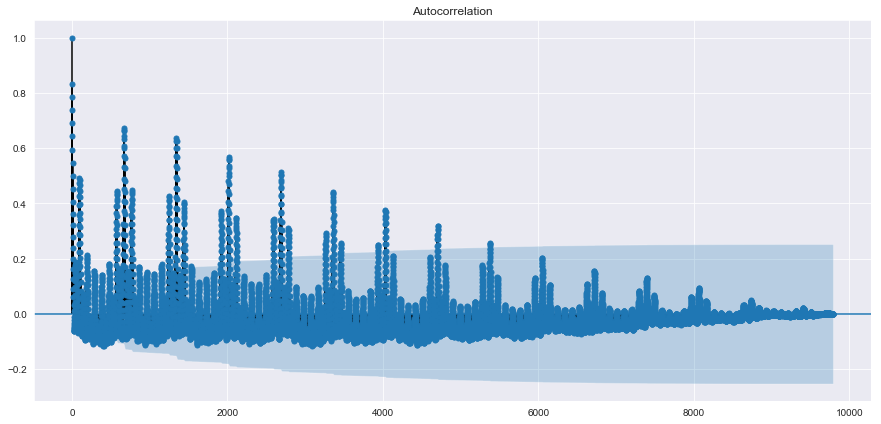

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
fig = plot_acf(logins_15min_df, ax=ax)
#fig = plot_pacf(logins_15min_df, alpha=0.05, ax=ax[1])

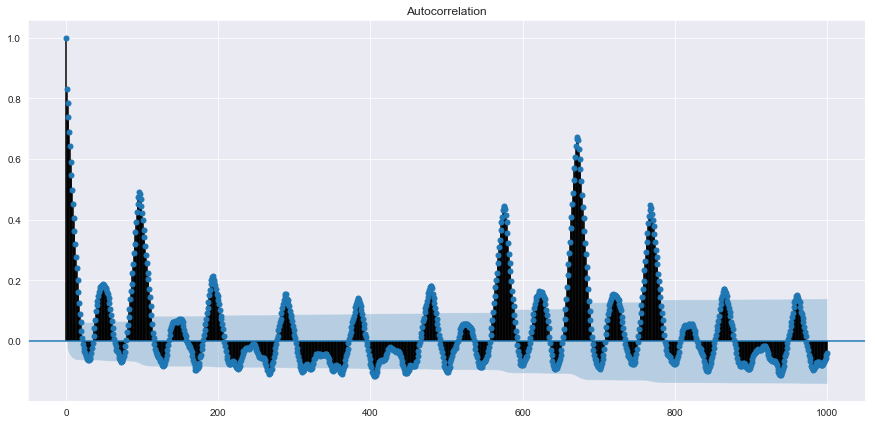

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
fig = plot_acf(logins_15min_df, lags=1000, ax=ax)
#fig = plot_pacf(logins_15min_df, alpha=0.05,  lags=1000, ax=ax[1])

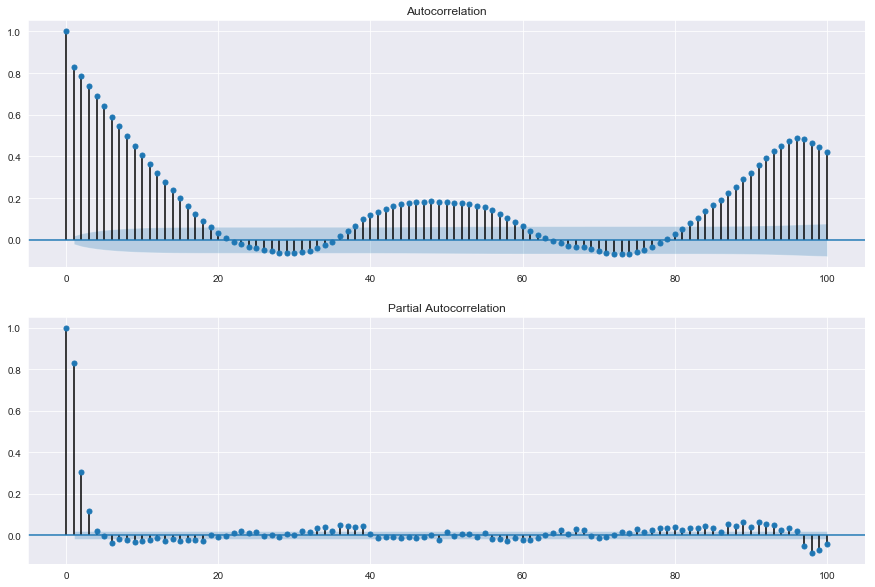

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))
fig = plot_acf(logins_15min_df, lags=100, ax=ax[0])
fig = plot_pacf(logins_15min_df, alpha=0.05,  lags=100, ax=ax[1])

#### The auocorrelation plots above show peaks every 96 lags which is 1 day (each lag is 15 minutes). There are also higher peaks every 672 lags which is 1 week. This indicates both daily and weekly seasonality in the data

#### Scatter plot (to check for outliers)

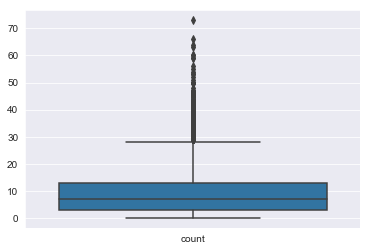

In [13]:
#fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=logins_15min_df)

In [14]:
interquartile_range = logins_15min_df['count'].quantile(0.75) - logins_15min_df['count'].quantile(0.25)
interquartile_range

10.0

In [15]:
outliers1 = logins_15min_df[logins_15min_df['count'] > 3*interquartile_range].sort_values(by='count', ascending=False)
outliers1[outliers1['count'] > 50].sort_index()

,count
login_time,
1970-03-01 04:30:00,73
1970-03-08 04:45:00,51
1970-03-13 22:15:00,55
1970-03-17 01:30:00,53
1970-03-29 04:45:00,52
1970-04-01 23:30:00,60
1970-04-04 00:30:00,53
1970-04-04 01:00:00,54
1970-04-04 01:15:00,63


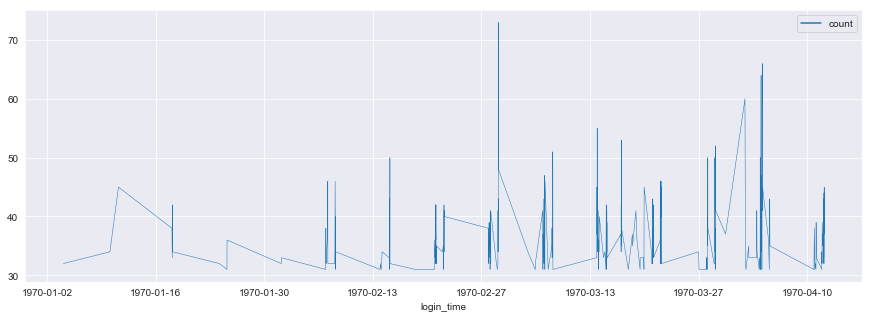

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=outliers1, ax=ax, linewidth=.5)

#### There seems to be abnormally high logins on 4th April around 1-2 am and again around 4:30 - 5:30 am. There are some other high usage days in March. This could be either due to issues recording data or unusually high usage scenarios which need to be further investigated

## Part 2 ‑ Experiment and Metrics Design

### What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

A rise in the (random variable representing the) number of rides that include a toll payment will be the key metric. A rise in this variable will be indicative of a successful experiment 

### Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

#### 1. how you will implement the experiment
A sample group of drivers will be selected. It will be made sure that there is ride-data for this group (including a field for each ride indicating if it involved a toll payment or not) over a significant time period (say 3 months) before the experiment is started. The drivers in this group will then be offered full reimbursement of toll charges over a time period of the same duration as before (3 months). Ride data will be collected during this period as well. Making sure that the group consists of less than 10% of the total population will ensure independence (as the sample will not be drawn with replacement). Ensuring that the group has at least 30 drivers will ensure that the sample is approximately normally distributed.
The ride data for all drivers in the group will be collected over a suitable period of time (say a few months (longer the better), to make sure that daily or weekly seasonality does not skew the data)
A statistical test (described next) will be conducted on the data to determine the success of the experiment

#### 2. what statistical test(s) you will conduct to verify the significance of the observation
A paired hypothesis test involving the two observation periods of the driver group will be conducted, the (null) hypothesis being that the mean number of toll payments per driver is the same for both periods. A significance level will also be specified before the experiment is executed.

#### 3. how you would interpret the results and provide recommendations to the city operations team along with any caveats
The p-value of the paired test will be computed. If the p-value is not lower than the significance level, the results will suggest that the experiment had no effect on driver behavior and that providing reimbursements will not cause drivers to be available in both cities. 
On the other hand, if the p-value is below the significance level, then the null hypothesis will be rejected. If the mean number of toll payments is higher after the reimbursements than before, a recommendation would be made to the city operations team that there is a probability of the reimbursements causing a rise in drivers being available in both cities. The experiment however cannot guarantee that there will be a significant rise in drivers who will be availiable in both cities if offered reimbursement.


## Part 3 ‑ Predictive modeling

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [17]:
import json
with open('ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)
ult_df = pd.DataFrame(data)
ult_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


#### add an is_active binary (0/1) field to indicate if user is active 6 months after the initial signup date. (is_active = 1 if last_trip_date is on or after 5 months from signup_date)

In [18]:
from datetime import datetime, timedelta
def is_active(signup, last_trip):
    """ returns if user is active """
    signup_dt = datetime.strptime(signup, '%Y-%m-%d')
    last_trip_dt = datetime.strptime(last_trip, '%Y-%m-%d')
    five_months = timedelta(weeks=20) 
    is_active_flag = 1 if ( (last_trip_dt - signup_dt) >= five_months )  else 0
    return is_active_flag

In [19]:
ult_df['is_active'] = ult_df.apply( lambda x: is_active(x['signup_date'], x['last_trip_date']), axis=1 )
ult_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


#### cleaning - check for nans/nulls

In [20]:
num_na_rows = len(ult_df[ult_df.isna().any(axis=1)])
total_rows = len(ult_df)
print('% of rows with null values {}'.format(num_na_rows/total_rows*100))

% of rows with null values 17.11


In [21]:
ult_df_cln = ult_df.dropna()
len(ult_df_cln)

41445

#### drop signup and last_trip dates as that information is now encoded in is_active

In [22]:
ult_df_cln = ult_df_cln.drop(['last_trip_date', 'signup_date'], axis='columns')

#### EDA

In [23]:
ult_df_active = ult_df_cln[ult_df_cln['is_active'] == 1]
ult_df_inactive = ult_df_cln[ult_df_cln['is_active'] == 0]

In [24]:
def make_boxplot(col):
    fig, ax= plt.subplots(figsize=(15, 5))
    ax.boxplot(x=[ult_df_active[col], ult_df_inactive[col]], vert=False)
    ax.set_xlabel(col)
    ax.set_yticklabels(['active', 'inactive'])
    plt.show()    

In [25]:
def make_countplot(col):
    num_vals = ult_df_cln[col].unique().shape[0]
    fig, ax= plt.subplots(figsize=(15, 2*num_vals))
    sns.countplot(y=col, hue="is_active", 
            palette="pastel", edgecolor=".6",
            data=ult_df_cln, ax=ax)

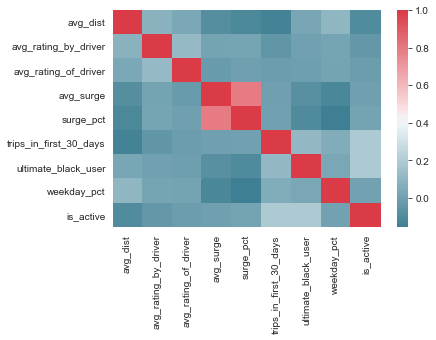

In [26]:
corr =  ult_df_cln.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap)

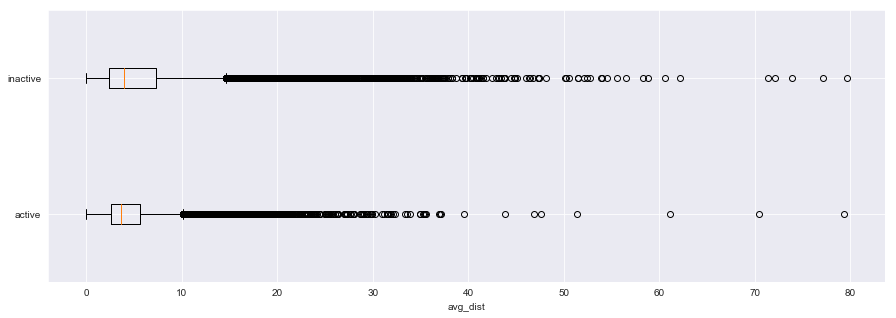

In [27]:
make_boxplot('avg_dist')

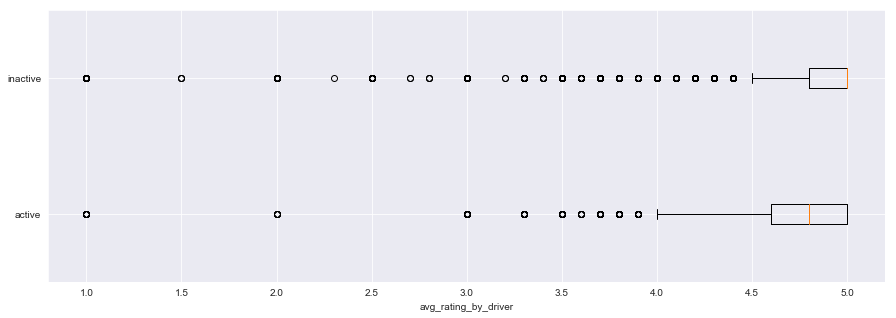

In [28]:
make_boxplot('avg_rating_by_driver')

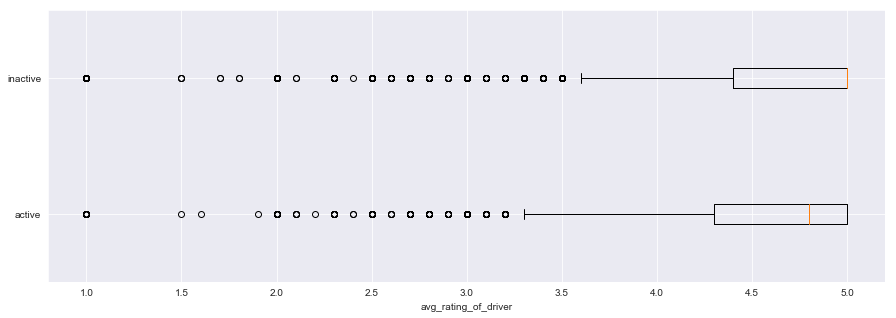

In [29]:
make_boxplot('avg_rating_of_driver')

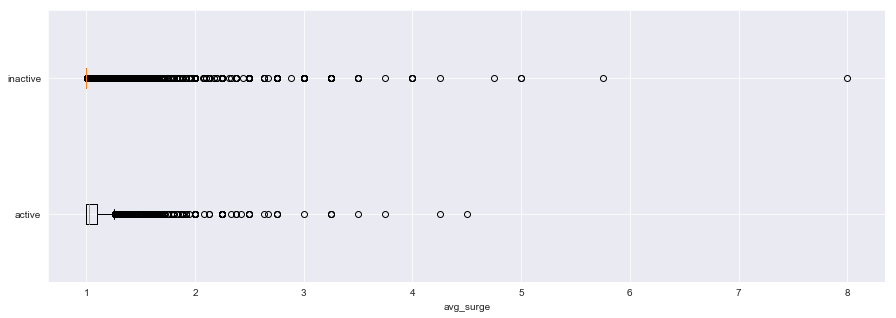

In [30]:
make_boxplot('avg_surge')

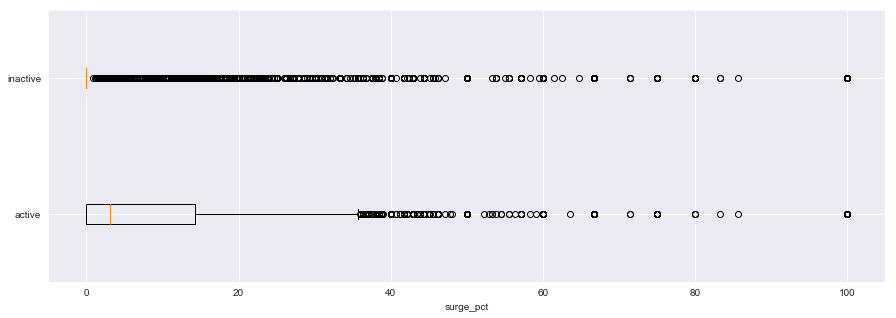

In [31]:
make_boxplot('surge_pct')

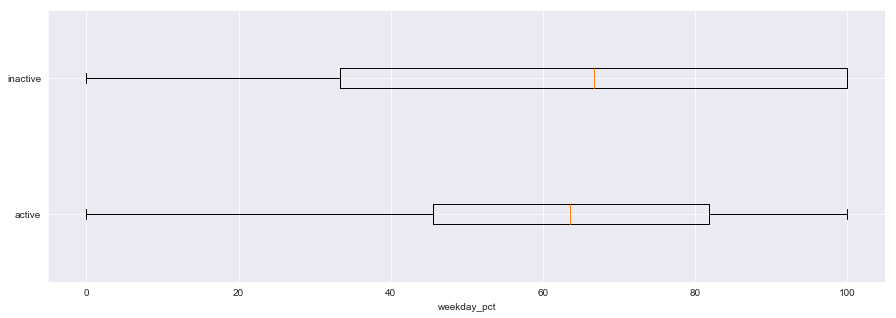

In [32]:
make_boxplot('weekday_pct')

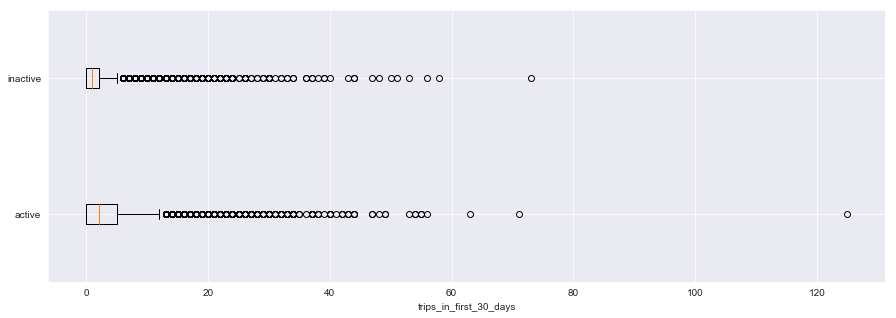

In [33]:
make_boxplot('trips_in_first_30_days')

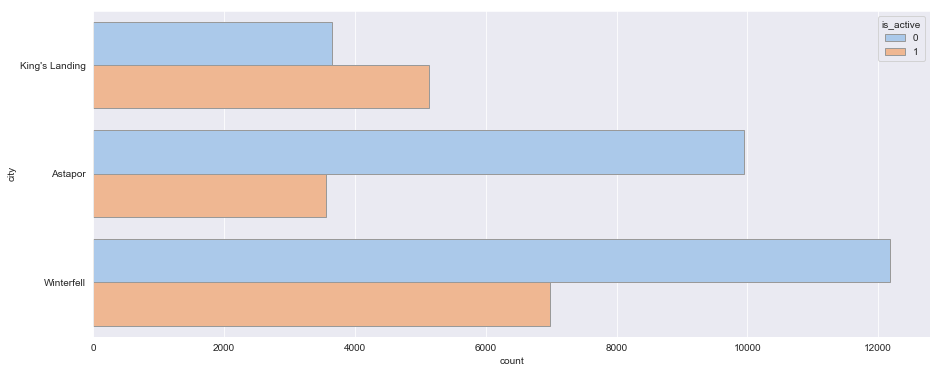

In [34]:
make_countplot('city')

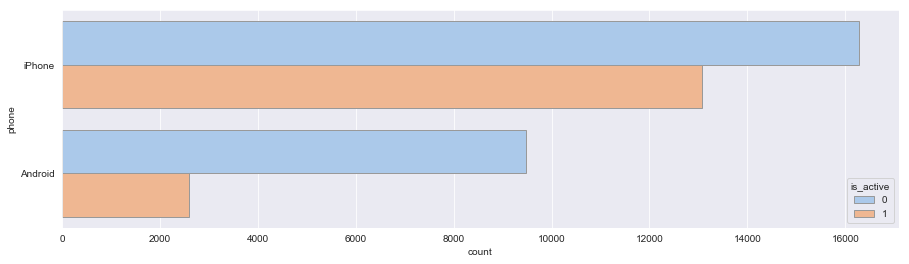

In [35]:
make_countplot('phone')

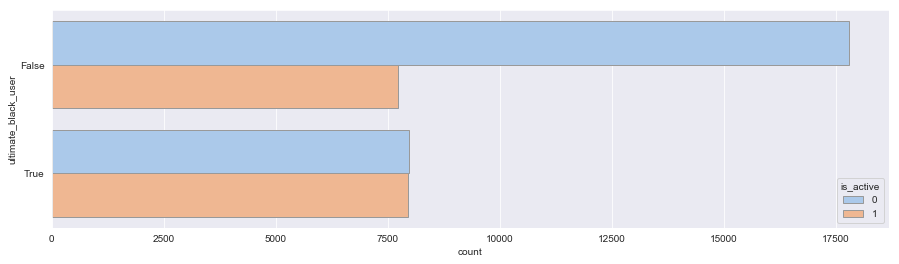

In [36]:
make_countplot('ultimate_black_user')

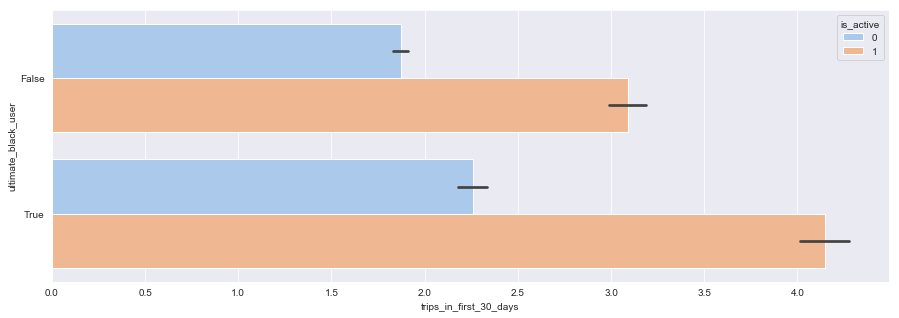

In [37]:
fig, ax= plt.subplots(figsize=(15, 5))
ax = sns.barplot(x="trips_in_first_30_days", y="ultimate_black_user", hue="is_active", data=ult_df_cln, 
                 ax=ax, orient='h', palette="pastel",)

#### Inferences from EDA
#### 1. users who are not 'ultimate black users' seem to be inactive more than users who are.
#### 2. android users seem to be inactive more than active
#### 3. users from cities Winterfell and Astapor seem to be inactive more than active
#### 4. there seems to be significant contribution of the number of trips in first 30 days, surge percentage and average surge on the active/inactive status of the user
#### 5. there is a very storng correlation between avg surge and surge percentage

#### What fraction of the observed users were retained?

In [38]:
retained_pct = len(ult_df_active)/len(ult_df_cln)*100
print('{:0.2f} % of observed users were retained.'.format(retained_pct))

37.82 % of observed users were retained.


### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

#### convert qualitative variables to categoricals

In [39]:
def make_categorical(df, column, inplace=True):
    # this is to convert boolean value columns to string to enable convertign to categories
    df[column] = df[column].astype('str')
    labels = df[column].astype('category').cat.categories.tolist()
    replace_map = {column: {k:v for k,v in zip(labels, list(range(1, len(labels)+1))) }}
    print(replace_map)
    return df.replace(replace_map, inplace=inplace)

In [40]:
make_categorical(ult_df_cln, 'city')
ult_df_cln.head()

{'city': {'Astapor': 1, "King's Landing": 2, 'Winterfell': 3}}


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active
0,3.67,5.0,4.7,1.10,2,iPhone,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,1,Android,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,1,iPhone,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,2,iPhone,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,3,Android,11.8,14,False,82.4,0


In [41]:
make_categorical(ult_df_cln, 'phone')
ult_df_cln.head()

{'phone': {'Android': 1, 'iPhone': 2}}


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active
0,3.67,5.0,4.7,1.10,2,2,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,1,1,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,1,2,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,2,2,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,3,1,11.8,14,False,82.4,0


In [42]:
make_categorical(ult_df_cln, 'ultimate_black_user')
ult_df_cln.head()

{'ultimate_black_user': {'False': 1, 'True': 2}}


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active
0,3.67,5.0,4.7,1.10,2,2,15.4,4,2,46.2,1
1,8.26,5.0,5.0,1.00,1,1,0.0,0,1,50.0,0
2,0.77,5.0,4.3,1.00,1,2,0.0,3,1,100.0,0
3,2.36,4.9,4.6,1.14,2,2,20.0,9,2,80.0,1
4,3.13,4.9,4.4,1.19,3,1,11.8,14,1,82.4,0


### Modeling

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

In [44]:
def plot_roc(fpr, tpr, roc_auc):
    df_real = pd.DataFrame(fpr, columns=['false positive rate'])
    df_real['true positive rate'] = pd.Series(tpr)
    df_real['curve'] = 'model'
    fpr_ideal = np.insert(fpr, 1, 0.00001)
    df_ideal = pd.DataFrame(fpr_ideal, columns=['false positive rate'])
    df_ideal['true positive rate'] = 1.0
    df_ideal['true positive rate'][0] = 0.0
    df_ideal['curve'] = 'ideal'
    df_worst = pd.DataFrame(fpr, columns=['false positive rate'])
    df_worst['true positive rate'] = pd.Series(fpr)
    df_worst['curve'] = 'random guess'
    df = pd.concat([df_real, df_ideal, df_worst])
    pal = {'model': "#3498db", 'random guess':"#e74c3c", 'ideal':"#34495e"}
    ax = sns.relplot('false positive rate', 'true positive rate', hue='curve', data=df,
                linewidth=2.0, palette=pal, kind="line", legend='full', height=5, aspect=7/5)
    ax.set(xlim=(-.05, 1.0), ylim=(0.0, 1.05), title='Receiver operating characteristic\n(area under curve = %0.2f)' % roc_auc)

#### Train-Test Split

In [45]:
from sklearn.model_selection import train_test_split
X = ult_df_cln.drop(['is_active'], axis='columns')
y = ult_df_cln['is_active']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)
print('Data shapes - \nX_train\t{}\nX_test\t{}\ny_train\t{}\ny_test\t{}'.\
      format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Data shapes - 
X_train	(27768, 10)
X_test	(13677, 10)
y_train	(27768,)
y_test	(13677,)


#### 1. Logistic Regression
##### Model hyperparameters are
##### 1. C - inverse of regularization strength (float)
##### 2. solver - optimizer (‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’)
##### 3. tol - tolerance for stopping criteria (float)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
params = {
        'C': np.linspace(0.1, 1.0, 5),
        'solver': ['newton-cg', 'lbfgs','sag'],
        'tol': np.logspace(-6, -3, 4)    
}
logr_cv = RandomizedSearchCV(LogisticRegression(penalty='l2',random_state=42), 
                             param_distributions=params, cv=5,
                             random_state=42, n_jobs=-1)
start = time.time()
logr_cv.fit(X_train, y_train)
end = time.time()
print('Logistic Regression tuning:\ntime taken {} seconds\nbest params {}'.format(end-start, logr_cv.best_params_))

Logistic Regression tuning:
time taken 33.067352533340454 seconds
best params {'tol': 1e-06, 'solver': 'newton-cg', 'C': 0.775}


In [47]:
mod_logr = LogisticRegression(penalty='l2',random_state=42, n_jobs=-1,
                             tol=logr_cv.best_params_['tol'],
                             solver=logr_cv.best_params_['solver'],
                             C=logr_cv.best_params_['C']
                             )
start = time.time()
mod_logr.fit(X_train, y_train)
end = time.time()
print('Logistic Regression training:\ntime taken {} seconds'.format(end-start))

Logistic Regression training:
time taken 4.690918207168579 seconds


In [48]:
start = time.time()
y_pred_logr = mod_logr.predict(X_test)
end = time.time()
print('Logistic Regression prediction on test data:\ntime taken {} seconds'.format(end-start))

Logistic Regression prediction on test data:
time taken 0.0020003318786621094 seconds


Logistic Regression evaluation:
accuracy	0.6806
precision	0.6304
recall	0.3844
roc auc	0.6232


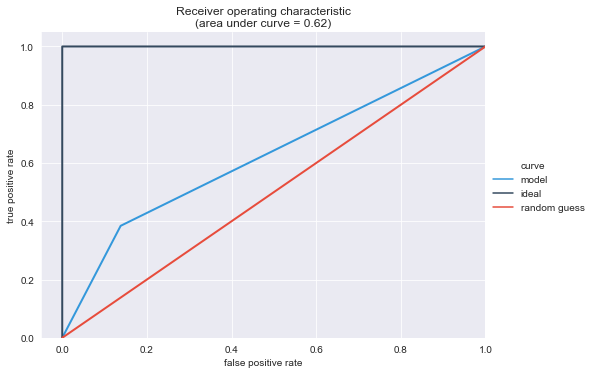

In [49]:
accuracy_logr = accuracy_score(y_test, y_pred_logr)
precision_logr = precision_score(y_test, y_pred_logr)
recall_logr = recall_score(y_test, y_pred_logr)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logr)
roc_auc_logr = roc_auc_score(y_test, y_pred_logr)
print('Logistic Regression evaluation:\naccuracy\t{:0.4f}\nprecision\t{:0.4f}\nrecall\t{:0.4f}\nroc auc\t{:0.4f}'.\
      format(accuracy_logr, precision_logr, recall_logr, roc_auc_logr))
plot_roc(fpr, tpr, roc_auc_logr)

#### 2. Gradient Boosted Machine (CatBoost)
##### Model hyperparameters are
##### 1. max_depth - maximum tree-depth for learner trees (int)
##### 2. learning_rate - learning rate for the gradient descent (float)
##### 3. n_estimators - maximum number of learner trees (int)
##### 4. bagging_temperature - determines how aggressive the Bayesian bootstrap bagging is (float)
##### 5. reg_lambda - l2 regularization coefficient of leaf-weights (float)

In [50]:
import catboost as cb
# Model selection
params_cb = {'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
               'loss_function':['Logloss', 'CrossEntropy'], 
               'learning_rate' : np.linspace(.1, 1, 5, endpoint=True),
               'bagging_temperature' : np.linspace(1, 20, 10, endpoint=True),
               'reg_lambda': np.linspace(0.1, 10, 10, endpoint=True),
               'max_depth' : np.linspace(1, 16, 16, endpoint=True, dtype=int)
                 }
cb_cv = RandomizedSearchCV(cb.CatBoostClassifier(random_state=42), param_distributions=params_cb, cv=5, n_jobs=3, random_state=42)
cb_cv.fit(X_train, y_train)

0:	learn: 0.6128630	total: 107ms	remaining: 10.6s
1:	learn: 0.5985298	total: 128ms	remaining: 6.27s
2:	learn: 0.5825667	total: 148ms	remaining: 4.79s
3:	learn: 0.5766136	total: 168ms	remaining: 4.04s
4:	learn: 0.5762116	total: 189ms	remaining: 3.6s
5:	learn: 0.5759005	total: 210ms	remaining: 3.29s
6:	learn: 0.5716720	total: 232ms	remaining: 3.08s
7:	learn: 0.5716199	total: 255ms	remaining: 2.93s
8:	learn: 0.5707905	total: 279ms	remaining: 2.82s
9:	learn: 0.5702092	total: 300ms	remaining: 2.7s
10:	learn: 0.5682529	total: 324ms	remaining: 2.62s
11:	learn: 0.5680983	total: 348ms	remaining: 2.55s
12:	learn: 0.5493786	total: 369ms	remaining: 2.47s
13:	learn: 0.5485538	total: 389ms	remaining: 2.39s
14:	learn: 0.5484275	total: 410ms	remaining: 2.32s
15:	learn: 0.5418528	total: 431ms	remaining: 2.26s
16:	learn: 0.5416874	total: 451ms	remaining: 2.2s
17:	learn: 0.5410145	total: 471ms	remaining: 2.15s
18:	learn: 0.5407902	total: 492ms	remaining: 2.1s
19:	learn: 0.5387595	total: 518ms	remaining: 

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=<catboost.core.CatBoostClassifier object at 0x000001E9CB88EDA0>,
          fit_params=None, iid=True, n_iter=10, n_jobs=3,
          param_distributions={'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 'loss_function': ['Logloss', 'CrossEntropy'], 'learning_rate': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 'bagging_temperature': array([ 1.     ,  3.11111,  5.22222,  7.33333,  9.44444, 11.55556,
       13.66667, 15.77778, 17.88889, 20.     ]), 'reg_lambda': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [52]:
mod_cb = cb.CatBoostClassifier(random_state=42, 
                             loss_function=cb_cv.best_params_['loss_function'],
                             max_depth=cb_cv.best_params_['max_depth'],
                             learning_rate=cb_cv.best_params_['learning_rate'],
                             n_estimators=cb_cv.best_params_['n_estimators'],
                             bagging_temperature=cb_cv.best_params_['bagging_temperature'],
                             reg_lambda=cb_cv.best_params_['reg_lambda']
                             )
start = time.time()
mod_cb.fit(X_train, y_train)
end = time.time()
print('CatBoost training:\ntime taken {} seconds'.format(end-start))

0:	learn: 0.6128630	total: 23.8ms	remaining: 2.36s
1:	learn: 0.5985298	total: 44.7ms	remaining: 2.19s
2:	learn: 0.5825667	total: 68.6ms	remaining: 2.22s
3:	learn: 0.5766136	total: 91.4ms	remaining: 2.19s
4:	learn: 0.5762116	total: 114ms	remaining: 2.16s
5:	learn: 0.5759005	total: 137ms	remaining: 2.15s
6:	learn: 0.5716720	total: 158ms	remaining: 2.09s
7:	learn: 0.5716199	total: 179ms	remaining: 2.06s
8:	learn: 0.5707905	total: 199ms	remaining: 2.02s
9:	learn: 0.5702092	total: 224ms	remaining: 2.01s
10:	learn: 0.5682529	total: 247ms	remaining: 2s
11:	learn: 0.5680983	total: 268ms	remaining: 1.96s
12:	learn: 0.5493786	total: 289ms	remaining: 1.93s
13:	learn: 0.5485538	total: 310ms	remaining: 1.9s
14:	learn: 0.5484275	total: 331ms	remaining: 1.88s
15:	learn: 0.5418528	total: 351ms	remaining: 1.84s
16:	learn: 0.5416874	total: 372ms	remaining: 1.82s
17:	learn: 0.5410145	total: 393ms	remaining: 1.79s
18:	learn: 0.5407902	total: 417ms	remaining: 1.78s
19:	learn: 0.5387595	total: 441ms	remaini

In [53]:
start = time.time()
y_pred_cb = mod_cb.predict(X_test)
end = time.time()
print('CatBoost prediction on test data:\ntime taken {} seconds'.format(end-start))

CatBoost prediction on test data:
time taken 0.014994621276855469 seconds


CatBoost evaluation:
accuracy	0.7633
precision	0.7224
recall	0.6117
roc auc	0.7339


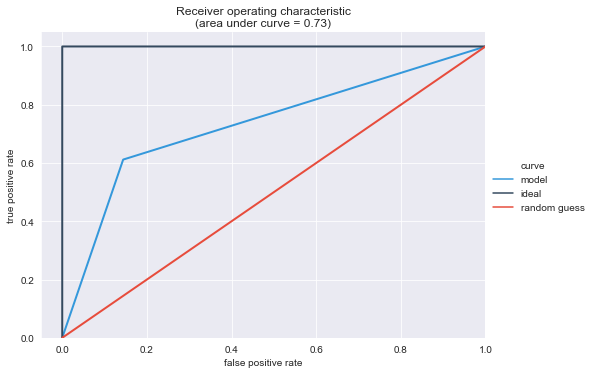

In [54]:
accuracy_cb = accuracy_score(y_test, y_pred_cb)
precision_cb = precision_score(y_test, y_pred_cb)
recall_cb = recall_score(y_test, y_pred_cb)
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, y_pred_cb)
roc_auc_cb = roc_auc_score(y_test, y_pred_cb)
print('CatBoost evaluation:\naccuracy\t{:0.4f}\nprecision\t{:0.4f}\nrecall\t{:0.4f}\nroc auc\t{:0.4f}'.\
      format(accuracy_cb, precision_cb, recall_cb, roc_auc_cb))
plot_roc(fpr_cb, tpr_cb, roc_auc_cb)

### Inference & Conclusion

#### Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
It is evident from the metrics and roc curve plots above that Gradient Boosted Machine (CatBoost) is an effective method for predictive modeling for this problem. The other option considered is Logistic Regression. But the significantly better accuracy, precision, recall and area-under-roc-curve for CatBoost signify that a linear-based model is probably too biased for this problem. 
The metric recall is important for this problem as it is necessary to keep false negatives low. False negatives are those users who would actually stay active but the model predicts them to become inactive. Gradient Boosted Machine raises the recall significantly from 38% (acheived by Logistic Regression) to 61%

#### Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).


#### Model Interpretation & Feature Importances

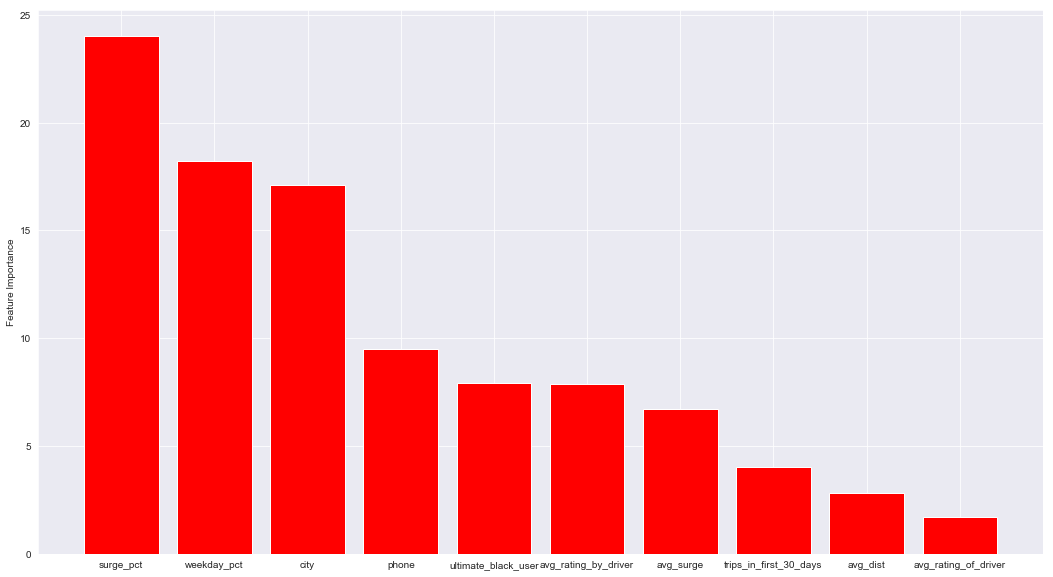

In [63]:
importances = mod_cb.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(18,10))
plt.bar(range(X_train.shape[1]), importances[sorted_idx], color='r', align='center')
#plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
# names of important features based on plot above
important_features_idx = [idx for idx in sorted_idx if importances[idx] > 0.0]
important_features = [X_train.columns[idx] for idx in important_features_idx]
plt.xticks(range(X_train.shape[1]), important_features)
plt.show()

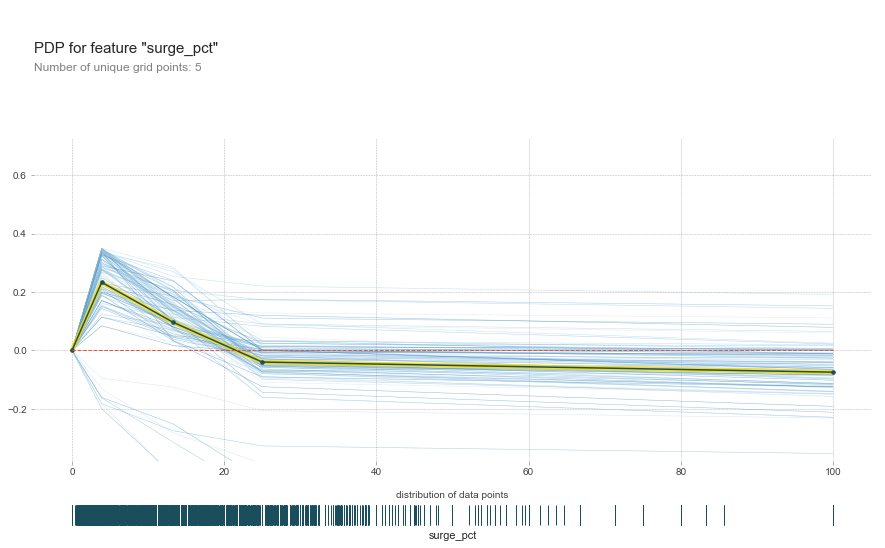

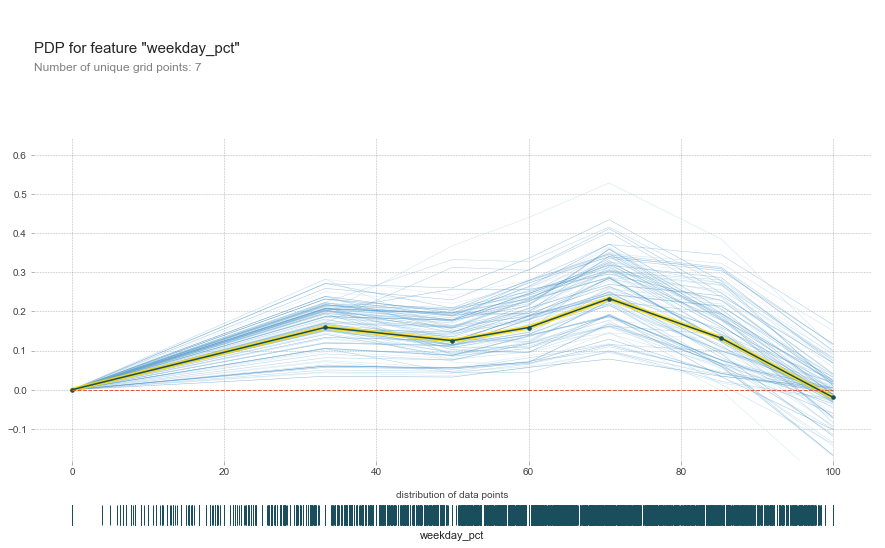

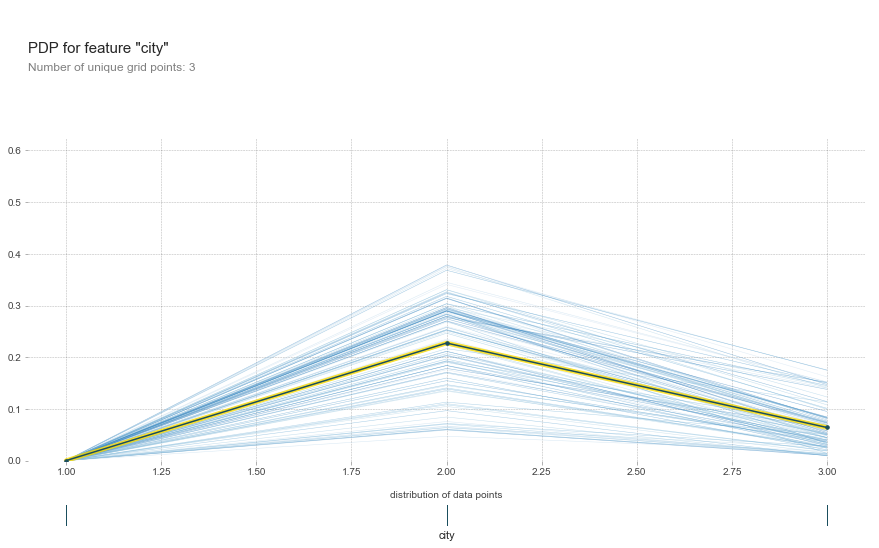

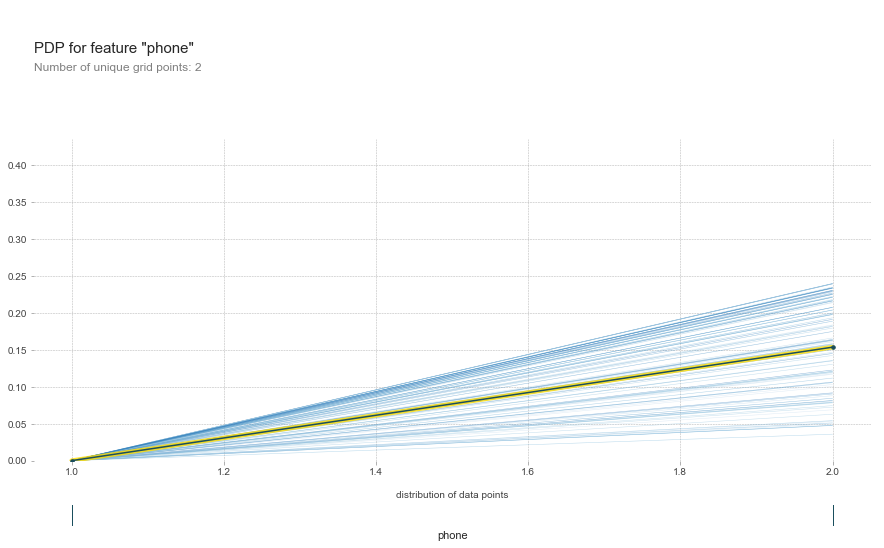

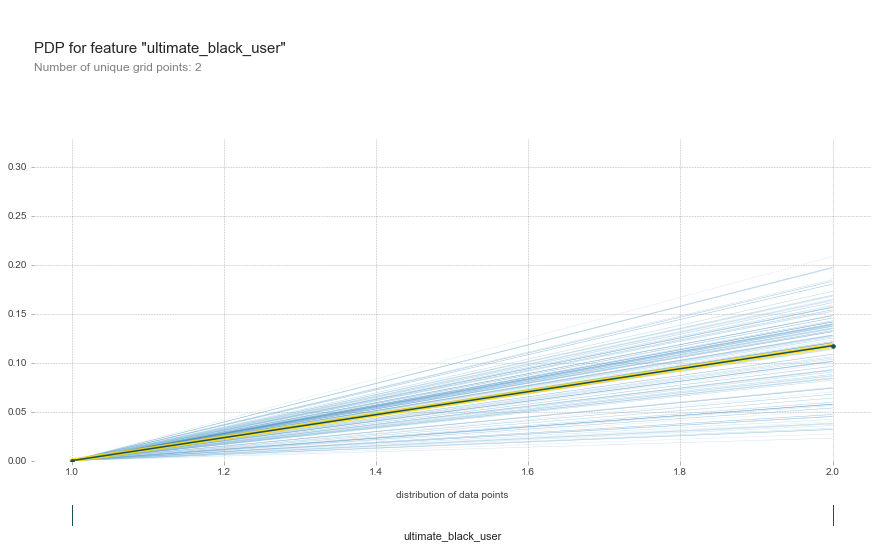

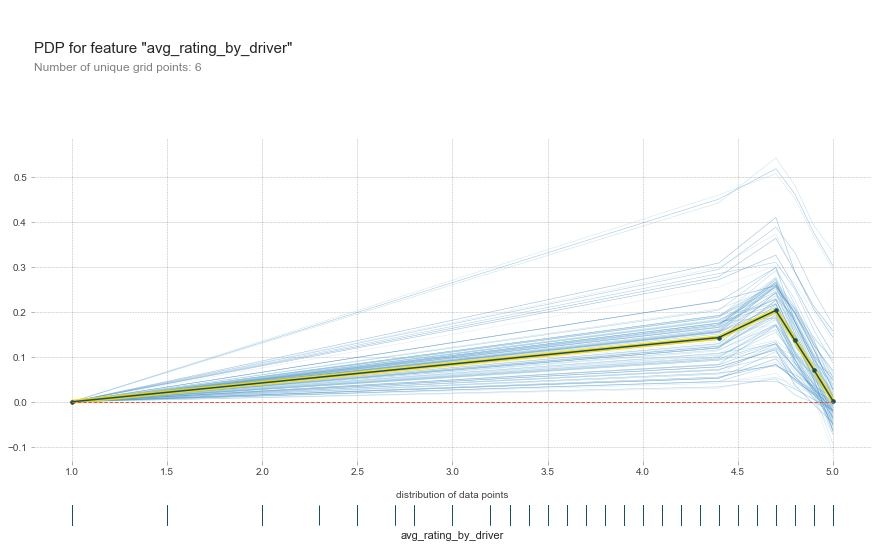

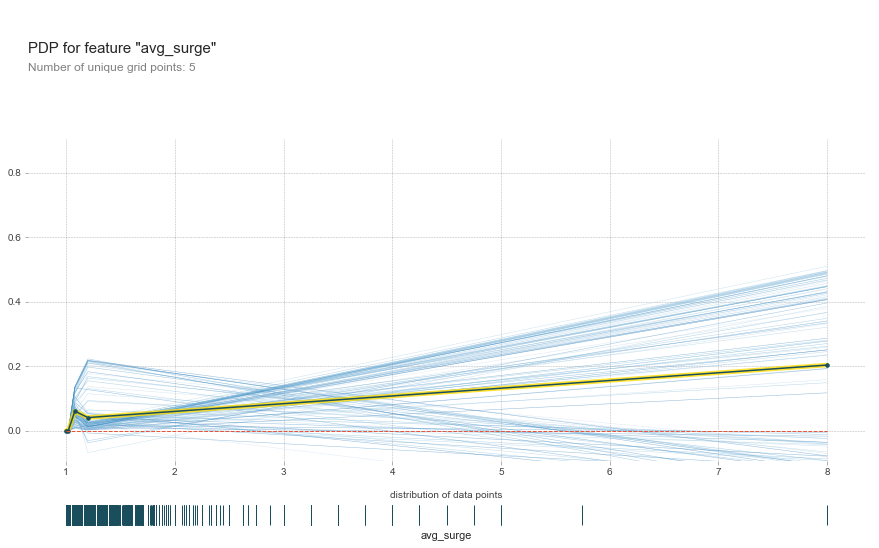

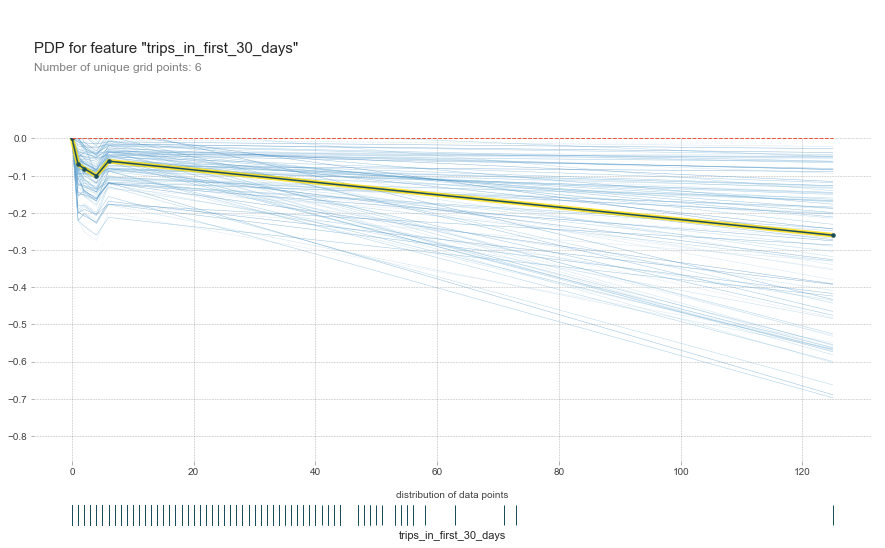

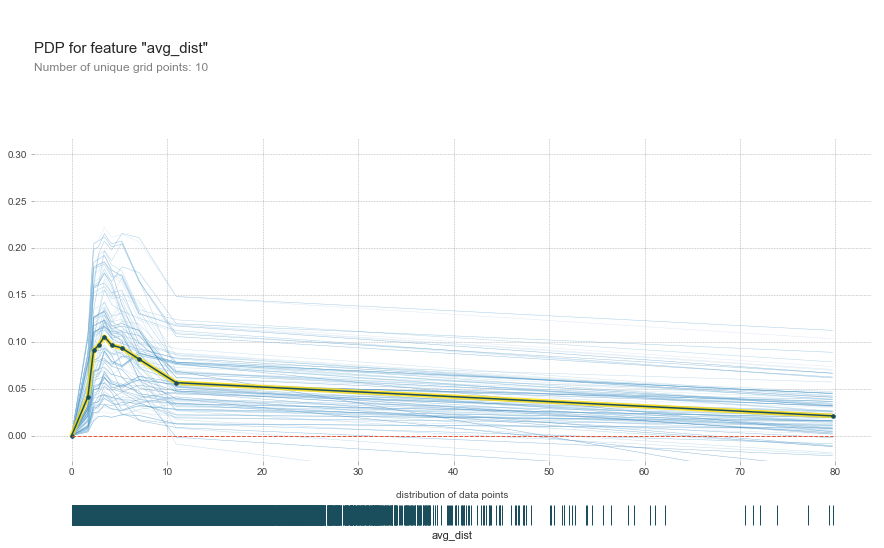

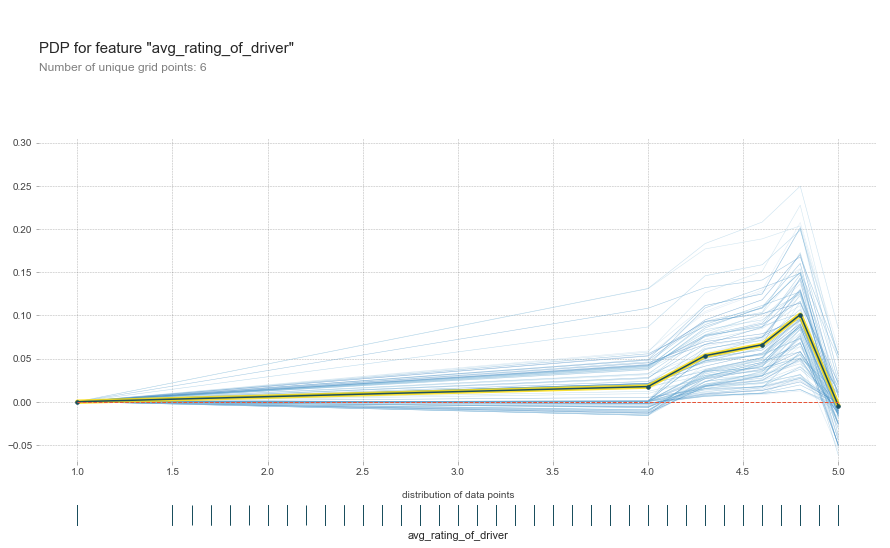

In [58]:
from pdpbox import pdp
for feature in list(important_features.values()):
#features=list(important_features.values())[:2]
    pdp_rf = pdp.pdp_isolate(mod_cb, ult_df_cln, X_train.columns, feature)
    pdp.pdp_plot(pdp_rf, feature, center=True,  plot_lines=True, frac_to_plot=100, plot_pts_dist=True)
    plt.show()

#### Suggestions to Ultimate
#### 1. Surge pricing - Retention is higher for those users who have taken a low number of surge-price trips (2%-15%, of total number of trips) Retention decreases linearly as the % of surge-price trips increases above 5%. This indicates that surge-pricing is not very popular and that customers will be loyal if trips are more often normally priced than surged.
#### 2. Weekday and weekedn usage - Retention is higher for those users who take a medium to high number of weekday trips (25%-80%, of total number of trips) Retention decreases linearly as the % of weekday trips increases above 80%. This indicates that most retained users are both weekday and weekend users. But those users who use very little on weekends do not tend to stay active. Ultimate must try to provide discounts and other incentives for users on weekends to encourage them to stay active. 
#### 3. Cities - User retention is highest for King's Landing, lower for Winterfell and the lowest for Astapor.Ultimate must try to provide discounts and other incentives to users from Astapor and Winterfell
#### 4. Phone - User retention is higher for iPhone users. Ultimate must try to provide discounts and other incentives to Android users (and also evaluate the quality of its Android app and improve it)
#### 5. Ultimate Black Users - User retention is higher for Ultimate Black Users. Ultimate must try to encourage users to become black users by making the membership more attractive to non-members